In [1]:
import mne
import pandas as pd
import numpy as np

# Read data from "derivatives/sub-xp101/eeg_pp/sub-xp101_task-motorloc_eeg_pp.vhdr"
data_raw=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr')


Extracting parameters from C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/sub-xp101/eeg/sub-xp101_task-motorloc_eeg.vhdr...
Setting channel info structure...


In [38]:
data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp109/eeg_pp/sub-xp109_task-motorloc_eeg_pp.vhdr',preload=True)

C:\Users\Alex\AppData\Local\Temp\ipykernel_11752\755564965.py:1: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp109/eeg_pp/sub-xp109_task-motorloc_eeg_pp.vhdr',preload=True)
C:\Users\Alex\AppData\Local\Temp\ipykernel_11752\755564965.py:1: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  data=mne.io.read_raw_brainvision('C:/Users/Alex/Documents/UPC/Q2/Neuroimatge/Final Project/ds002336-download/derivatives/sub-xp109/eeg_pp/sub-xp109_task-motorloc_eeg_pp.vhdr',preload=True)


In [34]:
%matplotlib tk

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'qt' is currently running

In [5]:
ssp_projectors = data_raw.info['projs']
ssp_projectors

# data.del_proj()

[]

Effective window size : 0.410 (s)


C:\Users\Alex\AppData\Local\Temp\ipykernel_11752\2311104215.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data_raw.plot_psd()


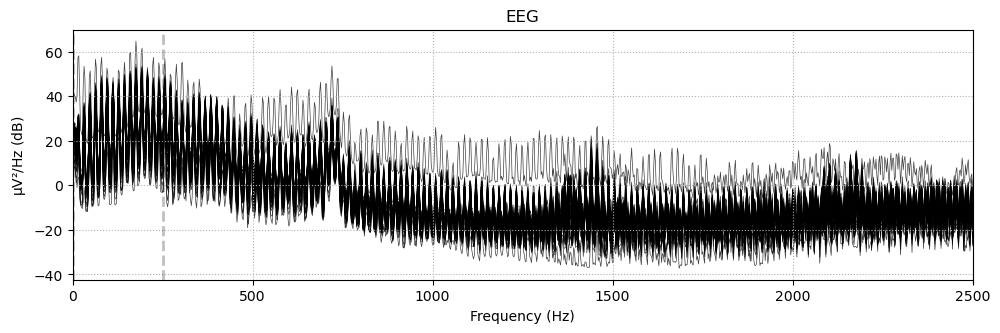

In [4]:
data_raw.plot_psd()

In [39]:
data.plot()

In [6]:
data_raw.plot()

Opening raw-browser...


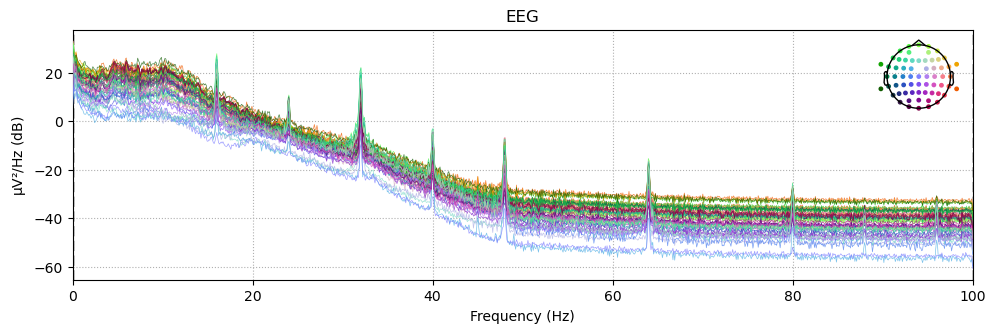

In [35]:
data.plot_psd()

In [40]:
data_filt=data.copy().load_data().crop(tmin=30).filter(2.5,40)

In [41]:
data.ch_names

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T7',
 'T8',
 'P7',
 'P8',
 'Fz',
 'Cz',
 'Pz',
 'Oz',
 'FC1',
 'FC2',
 'CP1',
 'CP2',
 'FC5',
 'FC6',
 'CP5',
 'CP6',
 'TP9',
 'TP10',
 'POz',
 'ECG',
 'F1',
 'F2',
 'C1',
 'C2',
 'P1',
 'P2',
 'AF3',
 'AF4',
 'FC3',
 'FC4',
 'CP3',
 'CP4',
 'PO3',
 'PO4',
 'F5',
 'F6',
 'C5',
 'C6',
 'P5',
 'P6',
 'AF7',
 'AF8',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'FT9',
 'FT10',
 'Fpz',
 'CPz']

In [51]:
data_filt.plot()

Opening raw-browser...


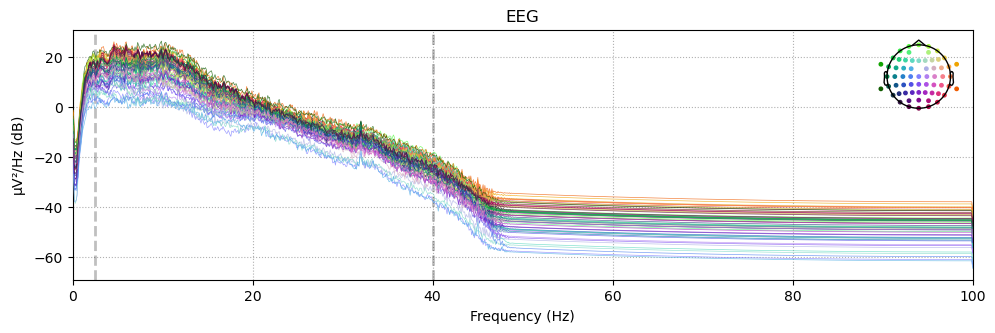

In [42]:

data_filt.plot_psd()

In [10]:
data_raw_filt=data_raw.copy().load_data().filter(1,45)

Reading 0 ... 1684699  =      0.000 ...   336.940 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 16501 samples (3.300 sec)



In [11]:
data_raw_filt.plot()

Opening raw-browser...


In [43]:
ica = mne.preprocessing.ICA(n_components=63, max_iter='auto', method='picard')
#other ICA methods with fit_params can be used
ica.fit(data_filt)
ica

Method,picard
Fit,216 iterations on raw data (78972 samples)
ICA components,63
Explained variance,100.0 %
Available PCA components,63
Channel types,eeg
ICA components marked for exclusion,—


In [46]:
ica.plot_sources(data_filt)

In [45]:
ica.plot_components()

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 585x260.5 with 3 Axes>]

In [11]:
ica.plot_properties(data_filt, picks=[8])
ica.plot_properties(data_filt, picks=[16])

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
162 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 700x600 with 6 Axes>]

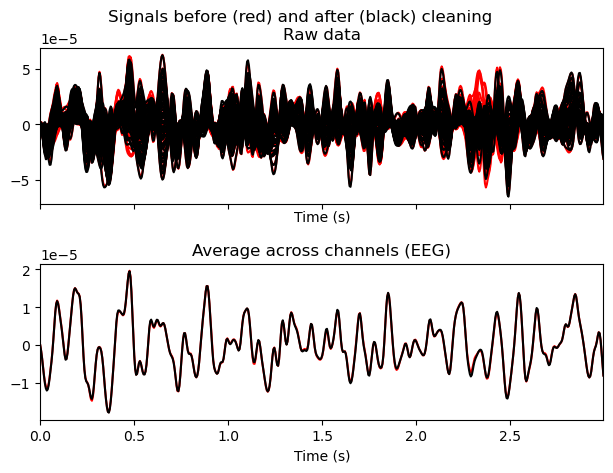

In [47]:
ica.plot_overlay(data_filt, exclude=[8,16])

In [59]:
# pick some channels that clearly show heartbeats and blinks
artifact_picks = mne.pick_channels(data_filt.ch_names, include=['Fp1','Fp2','AF3', 'AF4','AF7','AF8','Fpz'])
artifact_picks

array([ 0,  1, 38, 39, 52, 53, 62])

In [48]:
ica.exclude=[8,16]

In [49]:
reconst = data_filt.copy()
ica.apply(reconst)
data_filt.plot()
reconst.plot()

In [7]:
# testing
# montage=mne.channels.make_standard_montage('ioc', head_size='auto')
# print(montage)

ValueError: Invalid value for the 'kind' parameter. Allowed values are 'EGI_256', 'GSN-HydroCel-128', 'GSN-HydroCel-129', 'GSN-HydroCel-256', 'GSN-HydroCel-257', 'GSN-HydroCel-32', 'GSN-HydroCel-64_1.0', 'GSN-HydroCel-65_1.0', 'biosemi128', 'biosemi16', 'biosemi160', 'biosemi256', 'biosemi32', 'biosemi64', 'easycap-M1', 'easycap-M10', 'mgh60', 'mgh70', 'standard_1005', 'standard_1020', 'standard_alphabetic', 'standard_postfixed', 'standard_prefixed', 'standard_primed', 'artinis-octamon', and 'artinis-brite23', but got 'ioc' instead.

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2000 samples (10.000 sec)

Number of ECG events detected : 428 (average pulse 79 / min.)
Not setting metadata
428 matching events found
No baseline correction applied
Using data from preloaded Raw for 428 events and 201 original time points ...
1 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


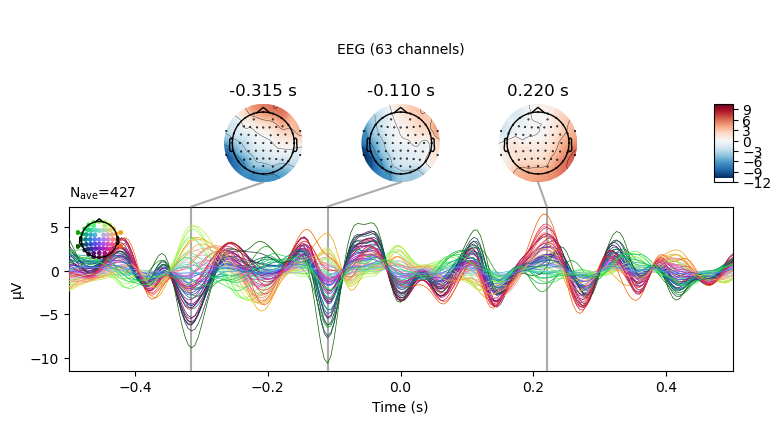

In [15]:
ecg_evoked = mne.preprocessing.create_ecg_epochs(reconst, ch_name='ECG').average()
ecg_evoked.plot_joint()

In [70]:
# eog_epochs = mne.preprocessing.create_eog_epochs(reconst, baseline=(-0.5, -0.2))
# eog_epochs.plot_image(combine='mean')
# eog_epochs.average().plot_joint()

RuntimeError: No EOG channel(s) found

In [16]:

for i in [20,22,24,26,34,40,42,48]:
    print(data.ch_names[i])
#names of the reference channels of the EEG used by the authors

FC1
CP1
FC5
CP5
C1
FC3
CP3
C5


In [4]:
# Another way to extract the events, not used

#events=pd.read_table('C:/Users/ernes/Desktop/Master/Course 21-22/2nd term 21-22/Neuroimage/Week 6/task-motorloc_events.tsv')
#dummies=pd.get_dummies(events,columns=['trial_type']).drop(columns=['duration','trial_type_Rest'])
#dummies['onset']=dummies['onset']*200
#events=dummies.to_numpy()

In [50]:
events=mne.events_from_annotations(data_filt) #extract the events from the data
# events[0][:,0]=events[0][:,0]-12*200 # no need to do this
events

(array([[ 8737,     0, 10003],
        [ 8799,     0, 10001],
        [ 8837,     0, 10002],
        [ 9946,     0,     1],
        [13952,     0,    99],
        [17959,     0,     1],
        [21962,     0,    99],
        [25966,     0,     1],
        [29969,     0,    99],
        [33973,     0,     1],
        [37976,     0,    99],
        [41983,     0,     1],
        [45987,     0,    99],
        [49990,     0,     1],
        [53994,     0,    99],
        [57999,     0,     1],
        [62005,     0,    99],
        [66008,     0,     1]]),
 {'Pulse Artifact/R': 10001,
  'Stimulus/S  1': 1,
  'Stimulus/S 99': 99,
  'TPULSE/TEND': 10002,
  'TPULSE/TSTART': 10003})

In [11]:
# #select events in the task blocks
# blockstart=False
# new_events=np.zeros([1,3],dtype=np.int16)
# for i in range(len(events[0])):
#     if events[0][i,2] == 1:
#         blockstart=True
#         j=1
#     while blockstart and i+j<558:
#         if events[0][i+j,2]==10001:
#             curr_event=events[0][i+j]
#             new_events=np.concatenate((new_events,np.expand_dims(curr_event,axis=0)),axis=0)
            
#         if events[0][i+j,2]==99:
#             blockstart=False
#         j=j+1
# new_events=new_events[1:]

In [52]:
#Create a new channel called stimulation (STI) needed to add the events
stim=mne.create_info(['STI'],200,['stim'])
stim_raw=mne.io.RawArray(np.zeros([1,78972]),stim)
reconst.load_data().add_channels([stim_raw],force_update_info=True)

<RawBrainVision | sub-xp109_task-motorloc_eeg_pp.dat, 65 x 78972 (394.9 s), ~39.3 MB, data loaded>

In [ ]:
reconst.ch_names #see the STI channel at the end

In [53]:
reconst.add_events(events[0],stim_channel='STI',replace=True) #add the events to the data

In [54]:
event_id = {'task':1,'rest':99} #take the value of the 'Stimulus/S 10001': 10001
tmin = 2  # start of each epoch (200ms before the trigger)
tmax = 18  # end of each epoch (500ms after the trigger) 
baseline = (2, 3) 

In [55]:
reject_criteria = dict(eeg=600e-5)      
picks = mne.pick_types(data_filt.info, meg=False, eeg=True, stim=False, misc=True,
                       include=[])

In [56]:
epochs = mne.Epochs(data_filt, events[0], event_id, tmin, tmax, picks=picks, proj=False,
                    baseline=baseline, reject=reject_criteria)

In [68]:
epochs.plot()

In [69]:
reconst.plot()

In [58]:
epochs2= mne.make_fixed_length_epochs(reconst.copy().crop(tmin=20, tmax=39))

In [60]:
epochs2.load_data().set_eeg_reference(ref_channels= ["FC1","CP1","FC5","CP5","C1","FC3","CP3","C5"]).plot()

In [65]:
epochs2.plot()

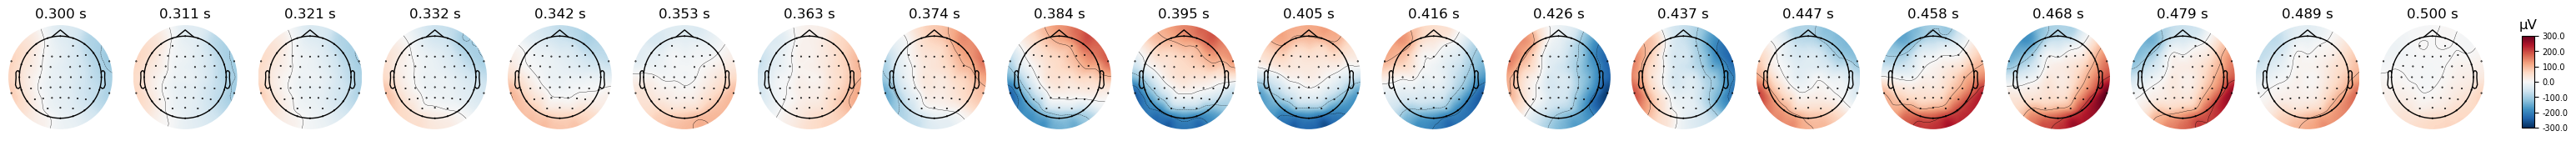

In [67]:
evoked2 = epochs2[5].set_eeg_reference(ref_channels= ["FC1","CP1","FC5","CP5","C1","FC3","CP3","C5"]).average() #mean of the epochs to get the evoked response
evoked2.plot(time_unit='s', gfp=True) #plot of the evoked response
evoked2.plot_topomap(times=np.linspace(0.3,0.5,20), ch_type='eeg',time_unit='s')

In [71]:
evokeds = [epochs[name].load_data().set_eeg_reference().average() for name in ('task', 'rest')]

# Show topography for different states
from mne.viz import plot_evoked_topo

colors = 'blue', 'red'
title = 'EEG data\ntask vs rest'

plot_evoked_topo(evokeds, color=colors, title=title, background_color='w')

plt.show()

NameError: name 'plt' is not defined

In [35]:
#matplotlib tk
czepochs=epochs.copy().load_data().pick_channels(['Cz'])
czepochs.plot()

In [20]:
epochs.load_data().set_eeg_reference().plot()

In [25]:
print(epochs['task'])

<Epochs |  8 events (all good), 2 - 18 sec, baseline 2 – 18 sec, ~92 kB, data not loaded,
 'task': 8>


In [39]:
epochs.plot_image(picks=['Pz'])

[<Figure size 640x480 with 4 Axes>]

Using data from preloaded Raw for 8 events and 3201 original time points ...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


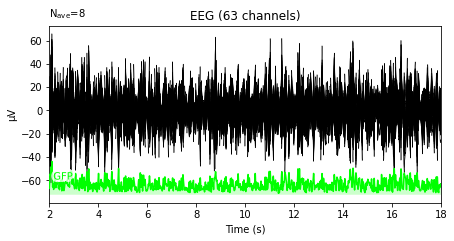

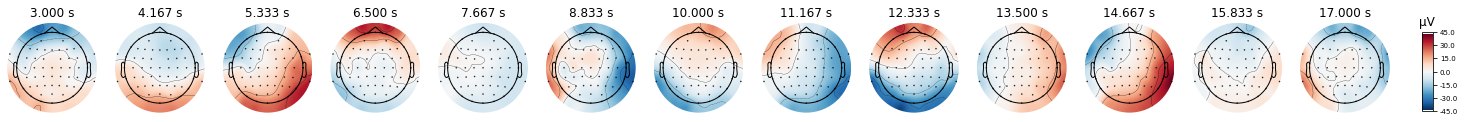

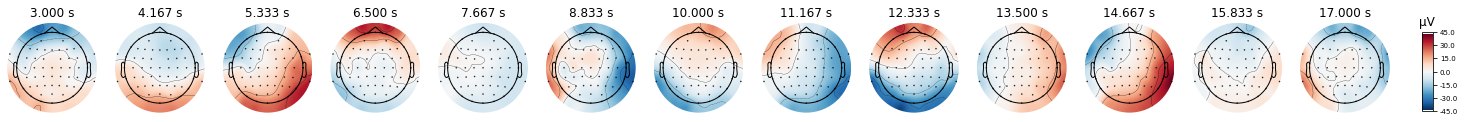

In [90]:
evoked = epochs['task'].load_data().set_eeg_reference(ref_channels= ["FC1","CP1","FC5","CP5","C1","FC3","CP3","C5"]).average() #mean of the epochs to get the evoked response
evoked.plot(time_unit='s', gfp=True) #plot of the evoked response
evoked.plot_topomap(times=np.linspace(3, 17, 13), ch_type='eeg',time_unit='s') #topomap

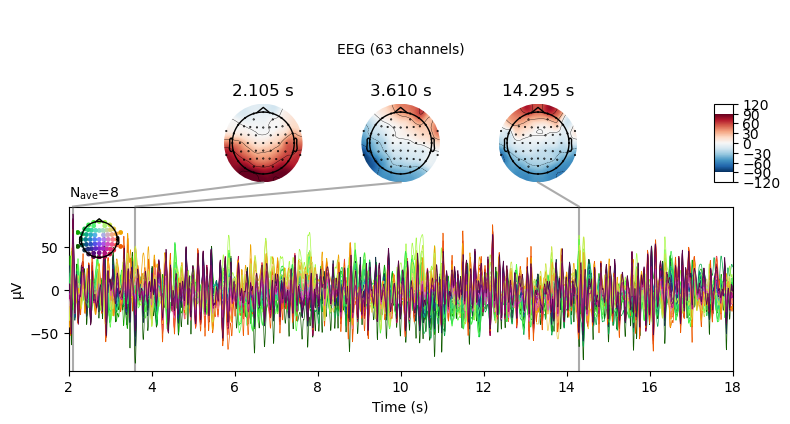

In [13]:
mne.viz.plot_evoked_joint(evoked)

# Time to make BEM and Source images!

In [14]:
noise_cov = mne.compute_covariance(
    epochs, method=['shrunk', 'empirical'], rank=None, verbose=True)

Using data from preloaded Raw for 8 events and 3201 original time points ...
Using data from preloaded Raw for 7 events and 3201 original time points ...
Computing rank from data with rank=None
    Using tolerance 5.9e-10 (2.2e-16 eps * 63 dim * 4.2e+04  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 63 data channels with 0 projectors
Reducing data rank from 63 -> 63
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 48015
log-likelihood on unseen data (descending order):
   shrunk: -245.945
   empirical: -267.525
selecting best estimator: shrunk
[done]


In [15]:
fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, data_filt.info)

C:\Users\Alex\AppData\Local\Temp\ipykernel_15676\355871161.py:1: RuntimeWarning: No average EEG reference present in info["projs"], covariance may be adversely affected. Consider recomputing covariance using with an average eeg reference projector added.
  evoked.plot_white(noise_cov, time_unit='s')


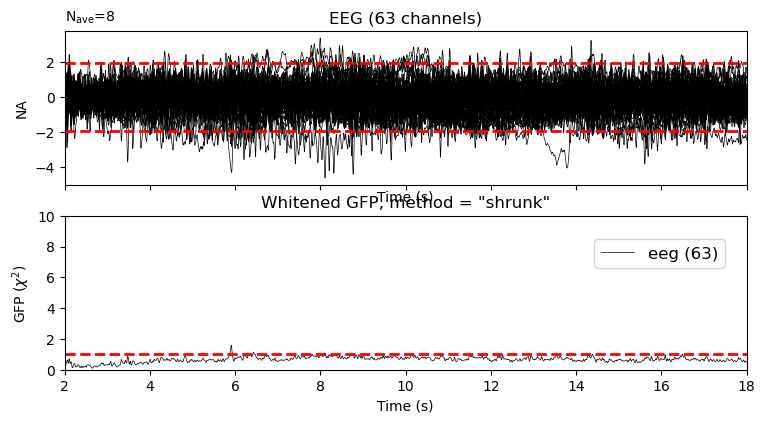

In [16]:
evoked.plot_white(noise_cov, time_unit='s')

In [39]:
mne.gui.coregistration()

KeyError: 'Key "SUBJECTS_DIR" not found in the environment or in the the mne-python config file (C:\\Users\\Alex\\.mne\\mne-python.json). Try either os.environ["SUBJECTS_DIR"] = VALUE for a temporary solution, or mne.utils.set_config("SUBJECTS_DIR", VALUE, set_env=True) for a permanent one. You can also set the environment variable before running python.'